In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt


**binary classification**

**multiclass classification**

**multilabel classification** - several classes for one object like tagging text

[batch_size, color_index, width, height]

# NN classification with PyTorch

In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42,
)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
len(X), len(y)

(1000, 1000)

In [6]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

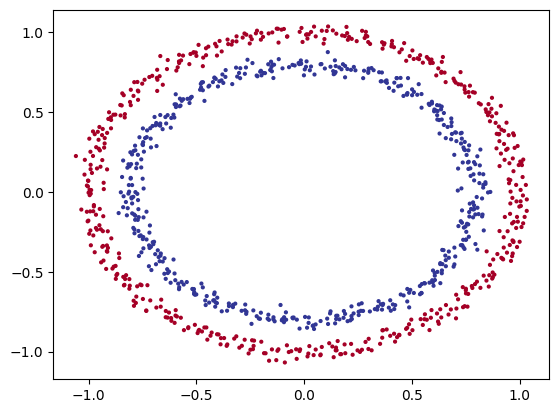

In [8]:
plt.scatter(
    circles["X1"],
    circles["X2"],
    s=4,
    c=y,
    cmap=plt.cm.RdYlBu
)

### 1.1 Check input and outputs shapes

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
X_sample = X[0]
y_sample = y[0]

print(X_sample.shape, y_sample.shape)

(2,) ()


### 1.2 Turn to tensors

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.shape

torch.Size([800, 2])

## 2. Building a model
1. Setup deviceagnostic code
2. Construct a model
3. Loss and opt
4. Training and testing loos

In [15]:
import torch
from torch import nn

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
device

'cuda'

In [18]:
class CirclesClassifierV0(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # self.layer_2 = nn.Linear(in_features=5, out_features=1)

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # return self.layer_2(self.layer_1(x))
        return self.two_linear_layers(x)

In [19]:
cc_v0 = CirclesClassifierV0().to(device)

In [20]:
cc_v0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[-0.2025,  0.0160],
                      [-0.2394, -0.5860],
                      [ 0.2992, -0.1496],
                      [ 0.3314, -0.2232],
                      [ 0.2370,  0.2730]], device='cuda:0')),
             ('two_linear_layers.0.bias',
              tensor([ 0.1623,  0.0654, -0.2135,  0.3254, -0.6930], device='cuda:0')),
             ('two_linear_layers.1.weight',
              tensor([[-0.1289,  0.1225, -0.4002,  0.3323, -0.1311]], device='cuda:0')),
             ('two_linear_layers.1.bias', tensor([0.1136], device='cuda:0'))])

In [21]:
cc_v1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

In [22]:
# Make predictions
with torch.inference_mode():
    untrained_preds = cc_v0(X_train.to(device))
print(untrained_preds.shape)
print(untrained_preds[100])

torch.Size([800, 1])
tensor([0.4566], device='cuda:0')


## Loss and opt


In [23]:
# BinaryCrossEntropy or CrossEntropy
# SGD or Adam
# loss_fn = nn.BCELoss() # Require applying of sigmoid for outputs
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation built-in
opt = torch.optim.SGD(
    params=cc_v0.parameters(),
    lr=0.1,
)

In [24]:
# Calculate accuracy - out of 100 how much get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred)
    return acc

## 3. Trainig model

### 3.1 Going from raw logits -> prediction probs -> predictions labels

Our model outputs are raw **logits**.
Apply activation function:
1. Sigmoid for binary classification
2. Softmax for multi-class classification

Then convert probs to prediction:
1. By rounding
2. By softmax

In [25]:
cc_v0.eval()
with torch.inference_mode():
    y_preds = torch.sigmoid(cc_v0(X_test.to(device)))
    y_pred_labels = torch.round(y_preds)

In [26]:
y_preds[:5]

tensor([[0.5786],
        [0.5660],
        [0.6118],
        [0.5691],
        [0.6129]], device='cuda:0')

In [27]:
# Find predicted labels
y_pred_labels = torch.round(y_preds)

In [28]:
accuracy_fn(y_pred_labels.squeeze(), y_test)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### 3.2 Training and testing

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    cc_v0.train()

    # Forward pass
    y_logits = cc_v0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # zero grad
    opt.zero_grad()

    # backward
    loss.backward()

    opt.step()

    cc_v0.eval()
    with torch.inference_mode():
        test_logits = cc_v0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}; Train loss: {loss}; Train acc: {acc}; Test loss: {test_loss}; Test acc: {test_acc}")

## 4. make predictions and eval the model

import a function called plot_decision_boundary

In [41]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("helper already exists")
else:
    req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(req.content)

from helper_functions import plot_decision_boundary

In [ ]:
def plot_decision_boundaries_for_train_and_test(model,
                                                X_train, y_train,
                                                X_test, y_test):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(
        model, X_train, y_train
    )
    plt.subplot(1, 2, 2)
    plot_decision_boundary(
        model, X_test, y_test
    )
    plt.title("Test")

plot_decision_boundaries_for_train_and_test(cc_v0, X_train, y_train,
                                            X_test, y_test)

## 5. Improving a model
These options are all from a model's perspective (hyperparameters):

* Add more layers
* Add more hidden units
* Changing the activation function
* Fit for longer
* Change the learning rate

There are from the data pers:
* Add data

** Remind the vanishing gradient and explosing gradient problems

In [ ]:
class CirclesClassifierV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_0 = nn.Linear(in_features=2, out_features=10)
        # nn.ReLU(),
        self.layer_1 = nn.Linear(in_features=10, out_features=10)
        # nn.ReLU(),
        self.layer_2 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(self.layer_0(x)))

In [ ]:
from typing import Tuple, Callable

In [ ]:
def train_step(model: nn.Module, loss_fn, opt,
               X_train: torch.Tensor, y_train: torch.Tensor,
               metric_fn: Callable | None) -> Tuple[float, float]:
    model.train()

    logits = model(X_train).squeeze()
    preds = torch.round(torch.sigmoid(logits))

    loss = loss_fn(logits, y_train)
    metric = metric_fn(y_train, preds) if metric_fn else None

    opt.zero_grad()
    loss.backward()
    opt.step()

    return loss.item(), metric

In [ ]:
def test_step(model: nn.Module, loss_fn,
              X_test: torch.Tensor, y_test: torch.Tensor,
              metric_fn: Callable | None) -> Tuple[float, float]:
    model.eval()
    with torch.inference_mode():
        logits = model(X_test).squeeze()
        preds = torch.round(torch.sigmoid(logits))

        loss = loss_fn(logits, y_test)
        metric = metric_fn(y_test, preds) if metric_fn else None

    return loss.item(), metric


In [ ]:
def train_test_loop(
        epochs: int,
        model: nn.Module, loss_fn, opt,
        X_train: torch.Tensor, y_train: torch.Tensor,
        X_test: torch.Tensor, y_test: torch.Tensor,
        metric_fn: Callable | None,
):
    for epoch in range(epochs):
        train_loss, train_metric = train_step(model, loss_fn, opt, X_train, y_train, metric_fn)

        if epoch % 100 == 0:
            test_loss, test_metric = test_step(
                model, loss_fn,
                X_test, y_test,
                metric_fn
            )

            print(f"Epoch: {epoch}; Train loss: {train_loss:.3f}; Train metric: {train_metric}; Test loss: {test_loss:.2f}; Test metric: {test_metric}")

    plot_decision_boundaries_for_train_and_test(model, X_train, y_train,
                                                X_test, y_test)

In [ ]:
cc_v2 = CirclesClassifierV2().to(device)

loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(
    params=cc_v2.parameters(),
    lr=0.005
)

epochs = 1000

In [ ]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
train_test_loop(
    epochs, cc_v2, loss_fn, opt,
    X_train, y_train,
    X_test, y_test,
    accuracy_fn,
)

### 5.1 Preparing data to see if our model can fit a straight line

* Try on smaller problem

In [ ]:
# Create some data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(X_regression.shape)

In [ ]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


In [ ]:
from helper_functions import plot_predictions

plot_predictions(
    X_train_regression, y_train_regression,
    X_test_regression, y_test_regression,
)

### 5.2 Adjust 'cc_v2' to fir straight line

In [ ]:
cc_v3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    # nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    # nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [ ]:
cc_v3

In [ ]:
loss_fn = nn.L1Loss()
opt = torch.optim.SGD(
    params=cc_v3.parameters(),
    lr=0.01,
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_test_regression = y_test_regression.to(device)


for epoch in range(epochs):
    cc_v3.train()
    y_pred = cc_v3(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)

    opt.zero_grad()
    loss.backward()
    opt.step()

    cc_v3.eval()
    with torch.inference_mode():
        test_pred = cc_v3(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}; Train loss: {loss}; Test loss: {test_loss}")

In [ ]:
from helper_functions import plot_predictions

cc_v3.eval()
with torch.inference_mode():
    test_pred = cc_v3(X_test_regression).to('cpu')

plot_predictions(
    X_train_regression, y_train_regression,
    X_test_regression, y_test_regression,
    test_pred
)

## 6. The missing piece of our model

### 6.1 Recreatin non-linear data

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, random_state=4, noise=0.03)
plt.scatter(X[:, 0], X[:, 1], s=4, c=y, cmap=plt.cm.RdYlBu)

In [ ]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train

In [ ]:
class CirclesClassifierV4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_0 = nn.Linear(in_features=2, out_features=10)
        self.layer_1 = nn.Linear(in_features=10, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = self.relu(self.layer_0(x))
        z = self.relu(self.layer_1(z))
        return self.layer_2(z)


In [ ]:
cc_v4 = CirclesClassifierV4()

loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(
    params=cc_v4.parameters(),
    lr=0.01,
)
# opt = torch.optim.SGD(
#     params=cc_v4.parameters(),
#     lr=0.7,
# )
epochs = 1000

In [ ]:
with torch.inference_mode():
    logit = cc_v4(X_train)
    print(logit[:5])

In [ ]:
for weight, value in cc_v4.state_dict().items():
    print(weight, value.shape)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
cc_v4.to(device)

train_test_loop(
    epochs, cc_v4, loss_fn, opt,
    X_train, y_train,
    X_test, y_test,
    accuracy_fn,
)

### 7. Replicate non-linear activation functions

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)

In [ ]:
plt.plot(A)

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

In [ ]:
plt.plot(relu(A))

In [ ]:
plt.plot(torch.sigmoid(A))

In [ ]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1/(1 + torch.exp(-x))

In [ ]:
plt.plot(sigmoid(A))

In [ ]:
class CirclesClassifierV5(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_0 = nn.Linear(in_features=2, out_features=10)
        self.layer_1 = nn.Linear(in_features=10, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        z = self.activation(self.layer_0(x))
        z = self.activation(self.layer_1(z))
        return self.layer_2(z)

In [ ]:
cc_v5 = CirclesClassifierV5()
opt = torch.optim.Adam(
    params=cc_v5.parameters(),
    lr=0.01
)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
cc_v5.to(device)

train_test_loop(
    400, cc_v5, loss_fn, opt,
    X_train, y_train,
    X_test, y_test,
    accuracy_fn,
)

## 8. Multiclass classification

### 8.1 Creating multiclass dataset

In [29]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
NUM_SAMPLES = 1000

# 1. Create dataset
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [31]:
# 3. Split on train, test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

Text(0.5, 1.0, 'Test Blobs')

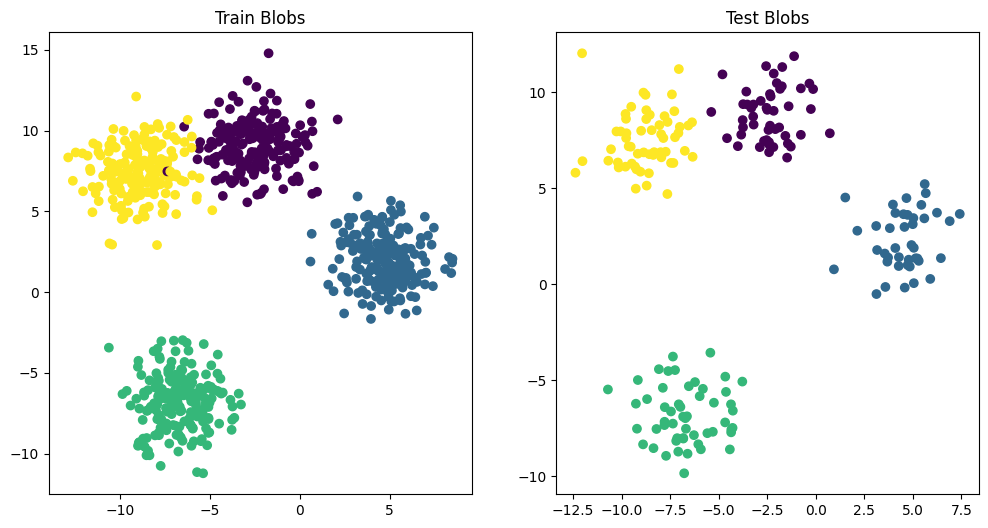

In [32]:
# 3.1 Visualise data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_blob_train[:, 0], X_blob_train[:, 1], c=y_blob_train)
plt.title("Train Blobs")
plt.subplot(1, 2, 2)
plt.scatter(X_blob_test[:, 0], X_blob_test[:, 1], c=y_blob_test)
plt.title("Test Blobs")

In [33]:
# 4. Create model
class BlobClassifier(nn.Module):
    def __init__(
            self,
            input_features: int,
            output_features: int,
            hidden_units=10,
    ):
        super().__init__()
        self.layers_stack = nn.Sequential(
            # nn.Linear(
            #     in_features=input_features,
            #     out_features=hidden_units,
            # ),
            # nn.ReLU(),
            # nn.Linear(
            #     in_features=hidden_units,
            #     out_features=hidden_units,
            # ),
            # nn.ReLU(),
            # nn.Linear(
            #     in_features=hidden_units,
            #     out_features=output_features,
            # )
            nn.Linear(
                in_features=input_features,
                out_features=output_features,
            )
        )
        self.last_activation = nn.Softmax()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # z = self.activation(self.layer0(x))
        # z = self.activation(self.layer1(z))
        # return nn.Softmax(self.layer2(z))
        x = self.layers_stack(x)
        # return self.last_activation(x)
        return x



In [34]:
# 5. Optimizer and loss
bcm = BlobClassifier(2, 4)

opt = torch.optim.SGD(
    params=bcm.parameters(),
    lr=0.1,
)
loss_fn = nn.CrossEntropyLoss()

In [35]:
# Move data to device
bcm.to(device)
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [36]:
bcm.eval()
with torch.inference_mode():
    preds = bcm(X_blob_test)
    # classes_probes = nn.Softmax()(preds)
    preds = torch.argmax(preds, dim=1)
preds[:10]

tensor([2, 0, 0, 2, 2, 0, 0, 2, 0, 2], device='cuda:0')

In [37]:
# Calculate accuracy - out of 100 how much get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred)
    return acc

In [38]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
# 6. Train and test loop
EPOCHS = 1000

for epoch in range(EPOCHS):
    bcm.train()

    logits = bcm(X_blob_train)
    preds = torch.softmax(logits, dim=1).argmax(dim=1)
    train_loss = loss_fn(logits, y_blob_train)

    train_acc = accuracy_fn(y_blob_train, preds)

    opt.zero_grad()

    train_loss.backward()

    opt.step()

    if epoch % 100 == 0:
        bcm.eval()
        with torch.inference_mode():
            test_logits = bcm(X_blob_test)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_blob_test)

            test_acc = accuracy_fn(y_blob_test, test_preds)

        print(f"E: {epoch}; TrainL: {train_loss}; TrainAcc: {train_acc}; TestL: {test_loss}; TrainAcc: {test_acc}")

E: 0; TrainL: 4.048640727996826; TrainAcc: 0.00125; TestL: 0.8653416633605957; TrainAcc: 0.475
E: 100; TrainL: 0.0657542273402214; TrainAcc: 0.99125; TestL: 0.06049481779336929; TrainAcc: 0.995
E: 200; TrainL: 0.04902012273669243; TrainAcc: 0.99125; TestL: 0.042707715183496475; TrainAcc: 0.995
E: 300; TrainL: 0.04228346422314644; TrainAcc: 0.99125; TestL: 0.035386040806770325; TrainAcc: 0.995
E: 400; TrainL: 0.03853793069720268; TrainAcc: 0.99125; TestL: 0.03124527633190155; TrainAcc: 0.995
E: 500; TrainL: 0.03612026572227478; TrainAcc: 0.99125; TestL: 0.028530579060316086; TrainAcc: 0.995
E: 600; TrainL: 0.0344170443713665; TrainAcc: 0.99125; TestL: 0.026589613407850266; TrainAcc: 0.995
E: 700; TrainL: 0.03314563259482384; TrainAcc: 0.99125; TestL: 0.025119978934526443; TrainAcc: 0.995
E: 800; TrainL: 0.03215651586651802; TrainAcc: 0.99125; TestL: 0.0239609032869339; TrainAcc: 0.995
E: 900; TrainL: 0.03136272355914116; TrainAcc: 0.99125; TestL: 0.0230183657258749; TrainAcc: 0.995


In [42]:
from helper_functions import plot_decision_boundary

def plot_decision_boundaries_for_train_and_test(model,
                                                X_train, y_train,
                                                X_test, y_test):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(
        model, X_train, y_train
    )
    plt.subplot(1, 2, 2)
    plot_decision_boundary(
        model, X_test, y_test
    )
    plt.title("Test")

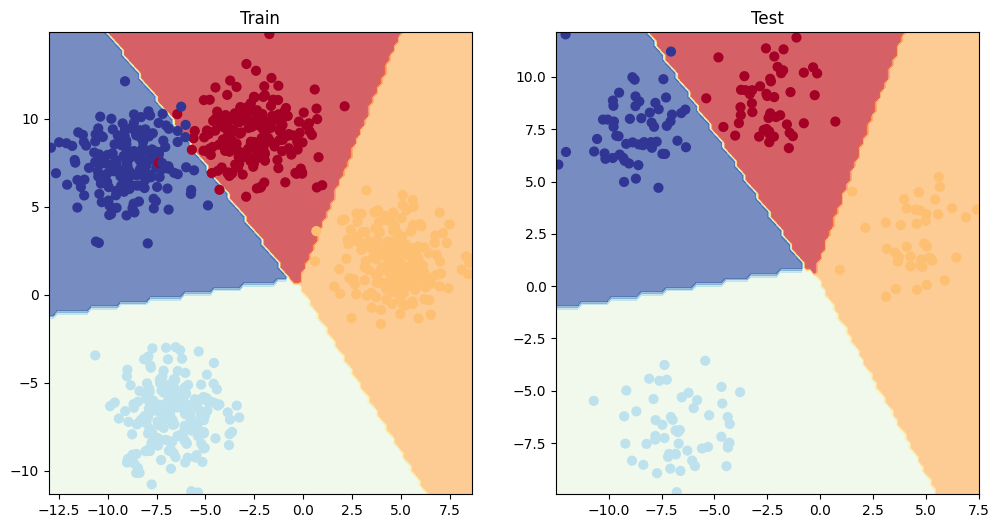

In [49]:
# 7. Predictions borders
bcm.to(device)
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

bcm.eval()
with torch.inference_mode():
    final_logits = bcm(X_blob_test)
    final_preds = torch.softmax(final_logits, dim=1).argmax(dim=1)

plot_decision_boundaries_for_train_and_test(
    bcm, X_blob_train, y_blob_train,
    X_blob_test, y_blob_test
)


## 9. Evaluation metrics

* TP, FP, TN, FN

* Accuracy = (TP + TN) (TP + TN + FP + FN)
(**torchmetrics.Accuracy()**, **sklearn.metrics.accuracy_score()**) [*not good for imbalanced*]

* Precision = TP / (TP + FP)
(**torchmetrics.Precision()**, **sklearn.metrics.precision_score()**)
how many of positive preds are done correctly

* Recall = TP /(TP + FN)
(**torchmetrics.Recall()**, **sklearn.metrics.recall_score()**)
how many of real positive class marked correctly

* F1-score = 2 * Precision * Recall / (Precision + Recall)


* Confusion matrix

* Classification report **sklearn.metrics.classification_report**

In [45]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.6 MB/s eta 0:00:00


In [46]:
import torchmetrics as tm

In [52]:
tm_acc = tm.Accuracy(
    task='multiclass',
    num_classes=4
).to(device)

tm_acc.device

device(type='cuda', index=0)

In [54]:
tm_acc(final_preds, y_blob_test)


tensor(0.9950, device='cuda:0')